## Time_Series_store_sales_model_factory

**Author:** Andrew Kruchko

**Label:** Time Series

**Scope**: The scope of this notebook is to provide instructions on how to combine time series into similar groups and build projects for the derived groups.

**Requirements:** Python 3.7; DataRobot API version 2.20

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datarobot as dr
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import mean_squared_error
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/Users/thodoris.petropoulos/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Define Functions

In [2]:
def run_project(data, cluster_name):
    
    # create a project
    project = dr.Project.create(project_name=f'{project_name}_{cluster_name}', sourcedata=data,max_wait=1500,
                                read_timeout= 1500)

    # define time-series project specs
    ts_specs = dr.DatetimePartitioningSpecification(
        datetime_partition_column=date_col,
        use_time_series=True,
        multiseries_id_columns=[series_id],

        feature_derivation_window_start=-7,
        feature_derivation_window_end=0,

        forecast_window_start=1,
        forecast_window_end=7,

        validation_duration='P0Y0M14DT0H0M0S',
        number_of_backtests = 3,
        calendar_id=calendar_id)

    # kickoff autopilot 
    project.set_target(
        target=target, 
        metric=metric, 
        partitioning_method=ts_specs, 
        worker_count=-1)
    
    return project   
    

In [3]:
def get_model_score(mod, metric):
    res = {}
    res['model_number'] = mod.model_number
    res['model_type'] = mod.model_type
    res['model_category'] = mod.model_category
    res['model'] = mod
    
    res['metric_v'] = mod.metrics.get(metric, {}).get('validation')
    res['metric_cv'] = mod.metrics.get(metric, {}).get('crossValidation')
    
    return res

def get_model_scores(proj, metric=None, ascending=True):
    """
    iterate trough the project models and get their performance metric
    """
    if metric is None:
        metric = proj.metric        
    df = pd.DataFrame([get_model_score(m, metric) for m in proj.get_models(with_metric=metric)])
    return df.sort_values(['metric_cv', 'metric_v'], ascending=ascending, na_position='last').reset_index(drop=True)

In [4]:
def get_train_preds(mod):
    """
    request and/or retrieve training predictions for a given model
    """
    
    preds = None
    
    try:
        # request training predictions and get job ids
        pred_job = mod.request_training_predictions(dr.enums.DATA_SUBSET.ALL_BACKTESTS)
        preds = pred_job.get_result_when_complete().get_all_as_dataframe()
    except:
        # retrieve training predictions if they were requested already
        train_preds = dr.TrainingPredictions.list(mod.project_id)
        for train_pred in train_preds:
            if train_pred.model_id == mod.id and train_pred.data_subset == 'allBacktests':
                preds = dr.TrainingPredictions.get(mod.project_id, train_pred.prediction_id).get_all_as_dataframe()
            
    preds.rename(columns={'timestamp': date_col, 'series_id': series_id}, inplace=True)
    preds.Date = preds.Date.str[:10]
    
    return preds

In [5]:
def rmse(x):
    return np.sqrt(mean_squared_error(x[target], x['prediction']))

#### Connect to DataRobot and Define Settings

In [6]:
dr.Client(config_path="../../drconfig.yaml")

In [7]:
project_name = 'ts_model_factory'
date_col = 'Date'
series_id = 'Store'
target = 'Sales'
metric = 'RMSE'

In [8]:
# import dataset
df = pd.read_csv('data/ts_model_factory.csv')
print(df.shape)

(7140, 17)


In [9]:
df.head()

,Store,Date,Sales,Store_Size,Num_Employees,Returns_Pct,Num_Customers,Pct_On_Sale,Marketing,Near_Xmas,Near_BlackFriday,Holiday,DestinationEvent,Pct_Promotional,Econ_ChangeGDP,EconJobsChange,AnnualizedCPI
0,Louisville,2012-07-01,109673.0,20100.0,68.0,1.03,531.0,9.96,July In Store Credit Card Signup Discount; In ...,0.0,0.0,No,No,0.000047,0.5,NaN,0.02
1,Louisville,2012-07-02,131791.0,20100.0,34.0,0.41,476.0,8.65,July In Store Credit Card Signup Discount; In ...,0.0,0.0,No,No,0.000047,NaN,NaN,NaN
2,Louisville,2012-07-03,134711.0,20100.0,42.0,0.31,578.0,8.96,July In Store Credit Card Signup Discount; In ...,0.0,0.0,No,No,0.000047,NaN,NaN,NaN
3,Louisville,2012-07-04,97640.0,20100.0,54.0,0.83,569.0,10.08,July In Store Credit Card Signup Discount; In ...,0.0,0.0,Yes,No,0.000047,NaN,NaN,NaN
4,Louisville,2012-07-05,129538.0,20100.0,62.0,0.51,486.0,9.80,July In Store Credit Card Signup Discount; ID5...,0.0,0.0,No,No,0.000047,NaN,NaN,NaN


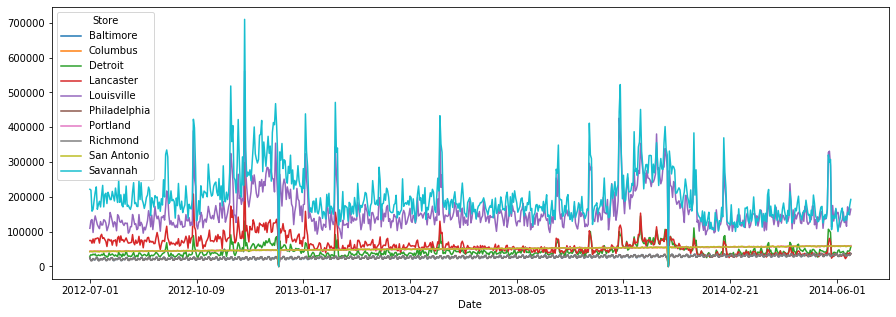

In [10]:
# make a pivot table to visualize Sales by Store over time
df_series = df.pivot(index=date_col, columns=series_id, values=target)
df_series.plot(figsize=(15,5))

#### Initiate DataRobot project for all data

In [11]:
# upload a celendar and run a project
calendar_id = dr.CalendarFile.create(f'data/calendar.csv').id
project = run_project(df, 'all')

In [ ]:
# wait for autopilot to finish
project.wait_for_autopilot()

#### Get the best model from project and its performance

In [13]:
best_model =  get_model_scores(project).model[0]
print(best_model)

Model('AVG Blender')


In [14]:
predictions = get_train_preds(best_model)
predictions = predictions.merge(df[[date_col, series_id, target]], on=[date_col, series_id])

In [15]:
# overall performance
rmse(predictions)

14939.606837139627

In [16]:
# performance by series
predictions.groupby('Store').apply(rmse)

Store
Baltimore        2625.273316
Columbus         2635.674736
Detroit         12072.164470
Lancaster        9288.234086
Louisville      33566.259333
Philadelphia     2674.636856
Portland         2614.063650
Richmond         2737.022842
San Antonio      2920.516503
Savannah        28798.780329
dtype: float64

#### Find clusters

In [17]:
# find clusters using TimeSeriesKMeans
# used approach may be replaced by any other which can reflect domain specifics e.g. cluster by SKU or store types
df_series_trans = TimeSeriesScalerMeanVariance().fit_transform(df_series.T.values)

km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=42)
cluster_num = km.fit_predict(df_series_trans)

83.113 --> 53.375 --> 53.375 --> 


In [18]:
# combine clusters into a dictionary
clusters = defaultdict(list)

for k, v in zip(cluster_num, df_series.columns):
    clusters[k].append(v)

clusters

defaultdict(list,
            {2: ['Baltimore', 'Philadelphia', 'Richmond'],
             0: ['Columbus', 'Portland', 'San Antonio'],
             1: ['Detroit', 'Lancaster', 'Louisville', 'Savannah']})

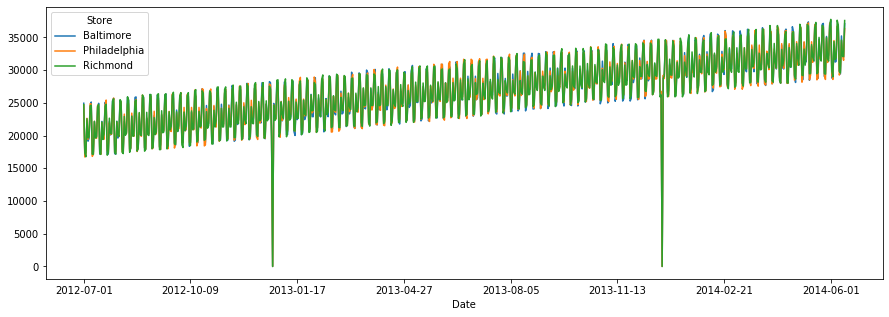

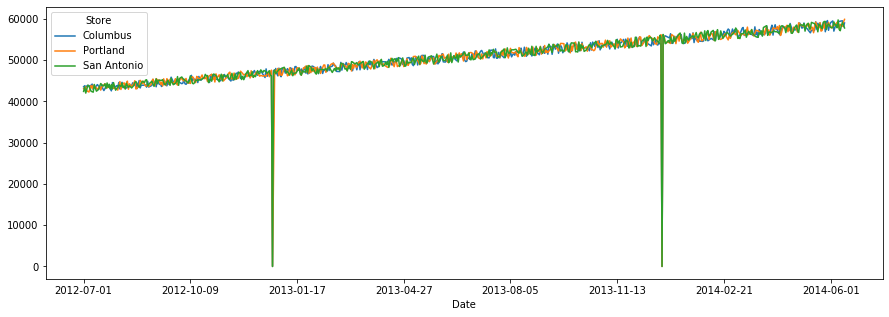

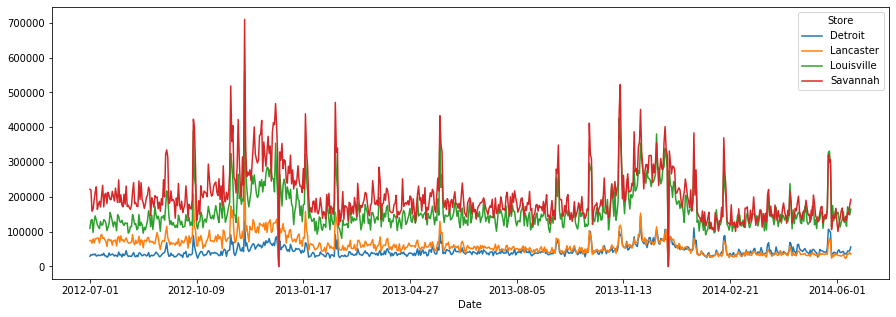

In [19]:
# the series within clusters look consistent
for _, v in clusters.items():
    df[df[series_id].isin(v)].pivot(index=date_col, columns=series_id, values=target).plot(figsize=(15,5))

#### Creating a mini model factory

In [20]:
projects = []

# create one project for each cluster
for k, v in clusters.items():
    temp_project = run_project(df[df[series_id].isin(v)], k)
    projects.append(temp_project)

In [ ]:
# wait for all autopilots to finish
for proj in projects:
    proj.wait_for_autopilot()

#### Getting the best model for each cluster and their performance

In [22]:
best_models = [] 

for proj in projects:
    best_models.append(get_model_scores(proj).model[0])
    
best_models

[Model('Ridge Regressor using Linearly Decaying Weights with Forecast Distance Modeling'),
 Model('AVG Blender'),
 Model('Ridge Regressor with Forecast Distance Modeling and Series Scaling')]

In [23]:
predictions_clusters = []

for best_mod in best_models:
    predictions_clusters.append(get_train_preds(best_mod))

predictions_clusters = pd.concat(predictions_clusters)
predictions_clusters = predictions_clusters.merge(df[[date_col, series_id, target]], on=[date_col, series_id])

In [24]:
# overall performance is much better
rmse(predictions_clusters)

11709.909620019636

In [25]:
# performance by series
predictions_clusters.groupby('Store').apply(rmse)

Store
Baltimore         457.093423
Columbus          881.664905
Detroit         11059.088293
Lancaster        7194.847622
Louisville      25572.860154
Philadelphia      407.945737
Portland          728.382671
Richmond          457.701127
San Antonio       797.372264
Savannah        23251.900335
dtype: float64